# Model selection

In this notebook I will elaborate on the hypotezis that it is enough to train a simple NN or linear classifier to predict rankings of films. I will try to select an appropriate model and then fine-tune it.

In [24]:
import pandas as pd
import sys
import os
sys.path.append("../")
from definitions import ROOT_DIR
import numpy as np

## Data splitting

In [25]:
data_folder = os.path.join(ROOT_DIR, 'data/interim')

In [26]:
data = pd.read_csv(os.path.join(data_folder, 'all.csv'))

In [27]:
data.head(2)

,rating,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Washington,West Virginia,Wisconsin,Wyoming,0-18,18-27,27-35,35-42,42-55,55+
0,3,0.534335,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3,0.534335,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [28]:
y = data['rating'].to_numpy()
X = data.drop('rating', axis=1, errors='ignore').to_numpy()
X.shape, y.shape

((100000, 103), (100000,))

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear classifier

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [33]:
model = LogisticRegression(random_state=42, n_jobs=-1, max_iter=10000)
model.fit(X_train, y_train)
print("Train accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy_score(y_test, model.predict(X_test)))

Train accuracy: 0.364525
Test accuracy: 0.3654


## Neural network

In [37]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

In [56]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train) - 1
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test) - 1

In [57]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [112]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [113]:
input_size = 103
hidden_size = 256
output_size = 5
model = NeuralNet(input_size, hidden_size, output_size)

In [118]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_losses = []
test_losses = []

In [119]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    model.eval()
    test_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()

    train_loss = running_loss/len(train_loader)
    test_loss = test_running_loss/len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}\t train loss: {train_loss}\t test loss: {test_loss}")

Epoch 1/20	 train loss: 1.2982089250326156	 test loss: 1.388896587753296
Epoch 2/20	 train loss: 1.2938591487169266	 test loss: 1.4016832685470582
Epoch 3/20	 train loss: 1.29053016269207	 test loss: 1.4071880680084228
Epoch 4/20	 train loss: 1.286571241927147	 test loss: 1.404522246170044
Epoch 5/20	 train loss: 1.2839393251419067	 test loss: 1.408512596130371
Epoch 6/20	 train loss: 1.2806153431892395	 test loss: 1.416289150238037
Epoch 7/20	 train loss: 1.2781246005296707	 test loss: 1.4174987997055053
Epoch 8/20	 train loss: 1.2742742233276367	 test loss: 1.4235759040832519
Epoch 9/20	 train loss: 1.2720451634645462	 test loss: 1.4324817722320558
Epoch 10/20	 train loss: 1.2691224004745483	 test loss: 1.4227589290618896
Epoch 11/20	 train loss: 1.2653989850759506	 test loss: 1.4218404930114745
Epoch 12/20	 train loss: 1.2645672659158707	 test loss: 1.4245735274314881
Epoch 13/20	 train loss: 1.2618408381700517	 test loss: 1.4236006361007691
Epoch 14/20	 train loss: 1.25866487114429

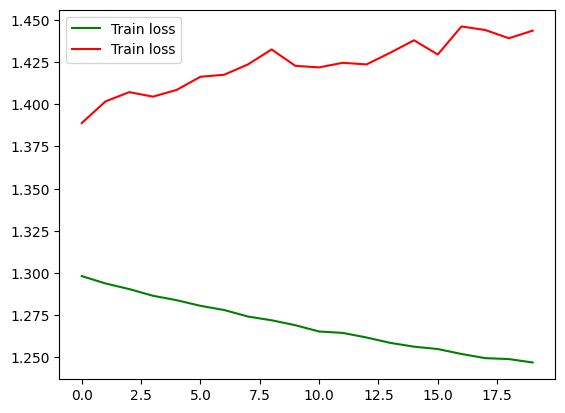

In [120]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train loss', color='green')
plt.plot(test_losses, label='Train loss', color='red')
plt.legend()
plt.show()

In [121]:
# Evaluation on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.39065


## Analyzing results

As we can see, this straightforward approach does not perform well (I have tried many NN architectures, regularizations, etc). We can clearly see that model can find train-specific patterns, but this patterns are not common, so the model just overfits. I believe this is because these models do not analyze data about a certain user or film, while it is essential to analyze each particular user info and ratings separately.

**Now I will try a different approach** to solve this task. I will engineer data again in '3.1-data-engineering.ipynb', train another model in '4.1-model-selection' and etc.